In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
# append this line to your .bashrc file
!export PATH=$PATH:/path/to/sleepy/bin
# reopen a new terminal window
# open jupyter-lab in new window
# check with following commands if sleepy is available to run

In [21]:
!which sleepy

/home/anon/projects2/sleepy/bin/sleepy


In [17]:
!echo $PATH | cut -d ":" -f 13 # remove the pipe to cut

/home/anon/projects2/sleepy/bin


In [29]:
from utils import sleepy

In [95]:
N = 200 # 400 haplotypes
L = 1_000_000
ms = {1:1, 00.5: 30}
r = 0.05 # 1e-7 = 0.01 / 1_000_000
bs = [1, 0.5]
dominance_coefficient = 0.5
selection_coefficient = 0.05
mutation_position = 500_000
use_tree_sequence_recording = True
max_generations = 10_000_000
generation_mutation_introduction = {1:21000, 0.5:41000}
dominance_coefficient = 0.5
stop_after_mrca = False
output_directory = "./demonstration/"

intermediate_table_generation = {1:20000, 0.5:40000}
intermediate_filename = {1: "intermediate_b1_r005", 0.5:"intermediate_b050_r005"}
continue_from = 0

The simulation has been split up into two phases to avoid running the initial calibration phase multiple times, when testing different parameters, i.e. different selection coefficients. Since in no selective mutation is introduced in the first phase the parameter "condition_on_fixation" has to be False. Otherwise, the programming ends in an infinite loop. Because Fixation cannot occur if not mutation is ever introduced. To summarize in phase 1, an unsimplified tree sequence will be generated, which will be the starting point of phase 2, where the selective allele is introduced. The calibrated tree sequence will saved into the "output_directory".

## Phase 1: Generating a tree sequence

In [98]:
n_simulations = 20

# since slurm is set to False and print_cmd is set to False, the simulation will run locally

slurm = False
print_cmd = False

In [99]:
%time

save_tables = True
load_tables = False
condition_on_fixation = False

for b in [1, 0.5]:
    
    file_name = output_directory + "N" + str(N) + "_b" + str(b) + "_m" + str(ms[b]) + "_r" + str(r) + "_s" + \
        str(selection_coefficient) + "_d" + str(dominance_coefficient) + "_L" + str(L) + "_cond_fix" + str(int(condition_on_fixation)) + "_stop_mrca" + str(int(stop_after_mrca))
    
    s = sleepy(n_simulations, 
               N=N, b=b, L=L, m=ms[b], r=r, selection_coefficient=selection_coefficient, dominance_coefficient=dominance_coefficient,
               max_generations=max_generations, use_tree_sequence_recording=use_tree_sequence_recording,
               file_name=file_name, stop_after_mrca=stop_after_mrca, mutation_position=mutation_position,
               generation_mutation_introduction=generation_mutation_introduction[b],
               condition_on_fixation=condition_on_fixation, output_directory=output_directory,
               print_cmd=print_cmd, n_parallel=10, continue_from=continue_from, save_tables=save_tables,
               load_tables=load_tables, intermediate_table_generation=intermediate_table_generation[b],
               intermediate_filename=intermediate_filename[b], slurm=False, slurm_limit=200, slurm_divide=2,
              )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


## Phase 2: Selection phase

In [100]:
save_tables = False
load_tables = True
condition_on_fixation = True

selection_coefficients = [0.2]

for b in [1, 0.5]:
    
    for selection_coefficient in selection_coefficients:
        
        file_name = output_directory + "N" + str(N) + "_b" + str(b) + "_m" + str(ms[b]) + "_r" + str(r) + "_s" + \
            str(selection_coefficient) + "_d" + str(dominance_coefficient) + "_L" + str(L) + "_cond_fix" + str(int(condition_on_fixation)) + "_stop_mrca" + str(int(stop_after_mrca))
        
        s = sleepy(n_simulations, 
               N=N, b=b, L=L, m=ms[b], r=r, selection_coefficient=selection_coefficient, dominance_coefficient=dominance_coefficient,
               max_generations=max_generations, use_tree_sequence_recording=use_tree_sequence_recording,
               file_name=file_name, stop_after_mrca=stop_after_mrca, mutation_position=mutation_position,
               generation_mutation_introduction=generation_mutation_introduction[b],
               condition_on_fixation=condition_on_fixation, output_directory=output_directory,
               print_cmd=print_cmd, n_parallel=10, continue_from=continue_from, save_tables=save_tables,
               load_tables=load_tables, intermediate_table_generation=intermediate_table_generation[b],
               intermediate_filename=intermediate_filename[b], slurm=False, slurm_limit=200, slurm_divide=2,
              )

## Visualization (Genetic diversity - Tajimas \pi):

In [101]:
import numpy as np
import os
import pandas as pd
import tskit

In [102]:
condition_on_fixation = True

In [105]:
wins = np.linspace(0, L, 201)
model = []
c = 0
for b in bs: 
    for selection_coefficient in selection_coefficients: 
        file_name = output_directory + "N" + str(N) + "_b" + str(b) + "_m" + str(ms[b]) + "_r" + str(r) + "_s" + str(selection_coefficient) + "_d" + str(dominance_coefficient) + "_L" + str(L) + "_cond_fix" + str(int(condition_on_fixation)) + "_stop_mrca" + str(int(stop_after_mrca))
        diversities = []
        c = 0
        for i in range(20):
            if os.path.exists(file_name + "_" + str(i) + ".csv"):
                ts = tskit.load(file_name + "_" + str(i) + ".trees")
                #print(i)
                c += 1
                #ts = msprime.mutate(ts, rate=5e-7)
                diversity = ts.diversity(windows=wins, mode="branch") 
                diversity = pd.DataFrame(diversity)
                diversity["x"] = diversity.index
                diversities.append(diversity)
                    
        diversities = pd.concat(diversities)
        diversities["b"] = b
        diversities["s"] = selection_coefficient
        model.append(diversities)

        print(file_name, c, b,  selection_coefficient)
        
model = pd.concat(model)
model.columns = ["diversity","x", "b", "s"]
model["position"] = model["x"] * (L/200) + (L/200/2)

models = model

./demonstration/N200_b1_m1_r0.05_s0.2_d0.5_L1000000_cond_fix1_stop_mrca0 20 1 0.2
./demonstration/N200_b0.5_m30_r0.05_s0.2_d0.5_L1000000_cond_fix1_stop_mrca0 20 0.5 0.2


In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sb_100_color =  "black"
sb_025_color = "#83aff0"
sb_035_color = "#4779c4"
sb_050_color = "#2c456b"

In [87]:
400 * 0.2, 400 / (0.5*0.5) * 0.2

(80.0, 320.0)

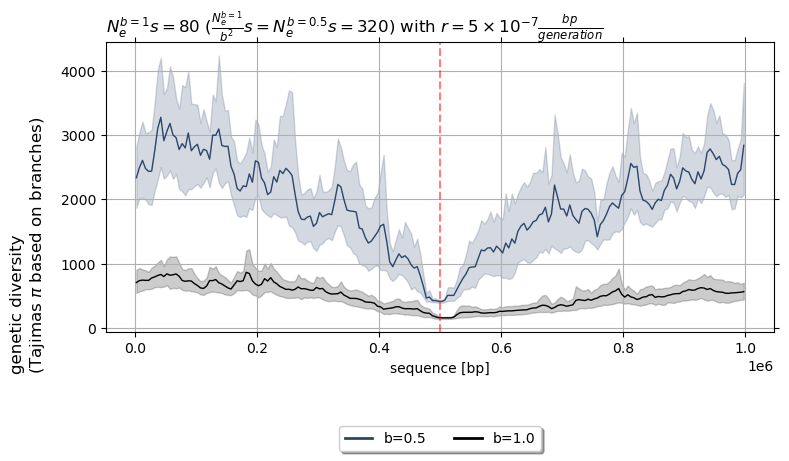

In [106]:
fig, ax = plt.subplots(1, figsize=(8,5))

models_s02 = models[models["s"] == 0.2]
sns.lineplot(data=models_s02, x="position", y="diversity", hue="b", palette=[sb_050_color, sb_100_color], ax=ax, legend=False, linewidth=1).set_title(r"$N^{b=1}_{e}s = 80$ $(\frac{N^{b=1}_{e}}{b^{2}}s=N^{b=0.5}_{e}s = 320)$ with $r=5\times10^{-7} \frac{bp}{generation}$", loc="left")

ax.grid(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.axvline(500_000, linestyle="--", color="red", alpha=0.5)
ax.set_xlabel("sequence [bp]")
    
ncol = 2
legend_pos=-0.3
leg = ax.legend(loc='upper center',labels=["b=0.5", "b=1.0"], bbox_to_anchor=(0.5, legend_pos), fancybox=True, shadow=True, ncol=ncol)
for line in leg.get_lines():
    line.set_linewidth(2.0)
ax.grid(True)
ax.tick_params(bottom=True, top=True, left=True, right=True)


fig.supylabel("genetic diversity\n(Tajimas $\pi$ based on branches)")
plt.tight_layout()

## Slurm example:

In [107]:
slurm = True
print_cmd = True

save_tables = True
load_tables = False
condition_on_fixation = False

## Phase 1 and 2:

In [109]:
for b in [1, 0.5]:
    
    file_name = output_directory + "N" + str(N) + "_b" + str(b) + "_m" + str(ms[b]) + "_r" + str(r) + "_s" + \
        str(selection_coefficient) + "_d" + str(dominance_coefficient) + "_L" + str(L) + "_cond_fix" + str(int(condition_on_fixation)) + "_stop_mrca" + str(int(stop_after_mrca))
    
    s = sleepy(n_simulations, 
               N=N, b=b, L=L, m=ms[b], r=r, selection_coefficient=selection_coefficient, dominance_coefficient=dominance_coefficient,
               max_generations=max_generations, use_tree_sequence_recording=use_tree_sequence_recording,
               file_name=file_name, stop_after_mrca=stop_after_mrca, mutation_position=mutation_position,
               generation_mutation_introduction=generation_mutation_introduction[b],
               condition_on_fixation=condition_on_fixation, output_directory=output_directory,
               print_cmd=print_cmd, n_parallel=10, continue_from=continue_from, save_tables=save_tables,
               load_tables=load_tables, intermediate_table_generation=intermediate_table_generation[b],
               intermediate_filename=intermediate_filename[b], slurm=slurm, slurm_limit=200, slurm_divide=2,
              )
    
save_tables = False
load_tables = True
condition_on_fixation = True

selection_coefficients = [0.2]

for b in [1, 0.5]:
    
    for selection_coefficient in selection_coefficients:
        
        file_name = output_directory + "N" + str(N) + "_b" + str(b) + "_m" + str(ms[b]) + "_r" + str(r) + "_s" + \
            str(selection_coefficient) + "_d" + str(dominance_coefficient) + "_L" + str(L) + "_cond_fix" + str(int(condition_on_fixation)) + "_stop_mrca" + str(int(stop_after_mrca))
        
        s = sleepy(n_simulations, 
               N=N, b=b, L=L, m=ms[b], r=r, selection_coefficient=selection_coefficient, dominance_coefficient=dominance_coefficient,
               max_generations=max_generations, use_tree_sequence_recording=use_tree_sequence_recording,
               file_name=file_name, stop_after_mrca=stop_after_mrca, mutation_position=mutation_position,
               generation_mutation_introduction=generation_mutation_introduction[b],
               condition_on_fixation=condition_on_fixation, output_directory=output_directory,
               print_cmd=print_cmd, n_parallel=10, continue_from=continue_from, save_tables=save_tables,
               load_tables=load_tables, intermediate_table_generation=intermediate_table_generation[b],
               intermediate_filename=intermediate_filename[b], slurm=slurm, slurm_limit=200, slurm_divide=2,
              )

for j in 0 100 ; do 
        sleepy  --N 200 --m 1 --b 1 --r 0.05 --L 1000000 --generation_mutation_introduction 21000 --n_generations_post_fixation 0 --max_generations 10000000 --selection_coefficient 0.2 --dominance_coefficient 0.5 --mutation_position 500000 --stop_after_mrca False --condition_on_fixation True --use_tree_sequence_recording True --file_name ./demonstration/N200_b1_m1_r0.05_s0.2_d0.5_L1000000_cond_fix1_stop_mrca0_$(($i+$j)) --output_directory ./demonstration/ --save_tables False --load_tables True --intermediate_table_generation 20000 --intermediate_filename intermediate_b1_r005_$(($i+$j)) 
        done
for j in 0 100 ; do 
        sleepy  --N 200 --m 30 --b 0.5 --r 0.05 --L 1000000 --generation_mutation_introduction 41000 --n_generations_post_fixation 0 --max_generations 10000000 --selection_coefficient 0.2 --dominance_coefficient 0.5 --mutation_position 500000 --stop_after_mrca False --condition_on_fixation True --use_tree_sequence_recording True --file_name ./demons

Add the slurm header at the beginning of the bash file, adapted to your specific cluster:

#!/bin/bash

#SBATCH --job-name=array   
#SBATCH --output=./log/array_%A_%a.out   
#SBATCH --error=./log/array_%A_%a.err   
#SBATCH --array=0-99   
#SBATCH --clusters=serial   
#SBATCH --partition=serial_std   
#SBATCH --get-user-env   
#SBATCH --time=12:00:00  
#SBATCH --ntasks=1   
#SBATCH --mem=5000mb    

conda activate sleepy    

i=$SLURM_ARRAY_TASK_ID    
